# GCN trên dữ liệu thực VRD + YOLO

In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from pathlib import Path
from PIL import Image
from ultralytics import YOLO

# Thiết lập device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 123
np.random.seed(SEED); torch.manual_seed(SEED)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import json
from collections import defaultdict
import numpy as np
import os


# Đường dẫn đến file bạn vừa upload
JSONL_PATH = "/content/rels_large.jsonl"  # Đảm bảo bạn đã upload file này lên Colab

def load_and_process_jsonl(filepath):
    if not os.path.exists(filepath):
        print(f"Lỗi: Không tìm thấy file {filepath}. Hãy upload file lên.")
        return [], [], []

    # Gom nhóm các quan hệ theo image_id
    # Cấu trúc: { image_id: [ {subj, obj, predicate}, ... ] }
    img_groups = defaultdict(list)

    # Tập hợp để xây dựng từ điển
    all_objects = set()
    all_predicates = set()

    print(f"Đang đọc file {filepath}...")
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.strip(): continue
            item = json.loads(line)

            img_id = item['image_id']

            # Chuẩn hóa text (viết thường, xóa khoảng trắng thừa)
            subj = item['subj'].lower().strip()
            obj = item['obj'].lower().strip()
            pred = item['predicate'].lower().strip()

            # Thêm vào từ điển
            all_objects.add(subj)
            all_objects.add(obj)
            all_predicates.add(pred)

            # Gom nhóm
            img_groups[img_id].append({
                'subj': subj,
                'obj': obj,
                'predicate': pred
            })

    print(f"Đã đọc xong. Tổng số ảnh: {len(img_groups)}")

    # Sắp xếp từ điển và thêm token đặc biệt
    # NODES_VOCAB: Danh sách các loại vật thể (person, horse, ...)
    nodes_vocab = sorted(list(all_objects)) + ['unknown']

    # REL_VOCAB: Danh sách các loại quan hệ (ride, on, ...)
    # Lưu ý: predicate 'none' dùng cho các cạnh không có quan hệ
    rel_vocab = sorted(list(all_predicates))
    if 'none' not in rel_vocab:
        rel_vocab.append('none')

    return img_groups, nodes_vocab, rel_vocab

# Thực hiện load data
if os.path.exists(JSONL_PATH):
    img_groups, NODES_VOCAB, REL_VOCAB = load_and_process_jsonl(JSONL_PATH)
else:
    print("⚠️ CHƯA UPLOAD FILE rels_large.jsonl. Đang dùng chế độ giả lập.")
    # (Dữ liệu giả lập để code không lỗi nếu quên upload file)
    img_groups = {}
    NODES_VOCAB = ['person', 'horse', 'unknown']
    REL_VOCAB = ['ride', 'none']

# Tạo map từ chữ sang số (ID)
node2id = {n: i for i, n in enumerate(NODES_VOCAB)}
rel2id  = {r: i for i, r in enumerate(REL_VOCAB)}
REL_NO_NONE = [r for r in REL_VOCAB if r != 'none']

print(f"Vocab: {len(NODES_VOCAB)} objects, {len(REL_VOCAB)} predicates.")
print(f"Sample Objects: {NODES_VOCAB[:5]}")
print(f"Sample Predicates: {REL_VOCAB[:5]}")



def one_hot(idx, size):
    v = np.zeros(size, dtype=np.float32)
    v[idx] = 1.0
    return v

def build_graph_from_group(rels, max_nodes=20):
    """
    Input: rels = danh sách các quan hệ của 1 ảnh cụ thể
    Output: A, X, R, mask
    """
    # Lấy danh sách các object xuất hiện trong ảnh này
    nodes_in_img = set()
    for r in rels:
        nodes_in_img.add(r['subj'])
        nodes_in_img.add(r['obj'])

    # Sắp xếp để cố định thứ tự và cắt nếu quá max_nodes
    nodes = sorted(list(nodes_in_img))[:max_nodes]

    N = len(nodes)
    F = len(NODES_VOCAB) # Kích thước vector one-hot

    # X: Node Features (One-hot)
    X = np.stack([one_hot(node2id.get(n, node2id['unknown']), F) for n in nodes], axis=0)

    # A: Ma trận kề, R: Ma trận nhãn quan hệ
    A = np.zeros((N, N), dtype=np.float32)
    R = np.full((N, N), rel2id['none'], dtype=np.int64)

    # Điền thông tin quan hệ vào ma trận
    for r in rels:
        s, o, p = r['subj'], r['obj'], r['predicate']
        if s in nodes and o in nodes and s != o:
            i = nodes.index(s)
            j = nodes.index(o)

            A[i, j] = 1.0 # Có kết nối từ s -> o
            # A[j, i] = 1.0 # Nếu muốn đồ thị vô hướng thì bỏ comment dòng này

            if p in rel2id:
                R[i, j] = rel2id[p]

    # Tạo nhãn giả lập cho bài toán phân loại đồ thị (Graph Classification)
    # Ví dụ: Nhãn 1 nếu trong ảnh có quan hệ "person ride horse"
    y = 0
    for r in rels:
        if r['subj'] == 'person' and r['obj'] == 'horse' and r['predicate'] == 'ride':
            y = 1
            break

    return A, X, R, y, nodes

# Chuyển đổi dictionary thành list các graph
all_graphs = []
if img_groups:
    for img_id, rels in img_groups.items():
        graph_data = build_graph_from_group(rels)
        all_graphs.append(graph_data)

# Chia train/val/test
def split_dataset(data_list, r_train=0.8, r_val=0.1):
    n = len(data_list)
    n_train = int(n * r_train)
    n_val = int(n * r_val)

    # Shuffle
    indices = np.random.permutation(n)
    train_idx = indices[:n_train]
    val_idx = indices[n_train : n_train + n_val]
    test_idx = indices[n_train + n_val:]

    return [data_list[i] for i in train_idx], \
           [data_list[i] for i in val_idx], \
           [data_list[i] for i in test_idx]

if all_graphs:
    train_data, val_data, test_data = split_dataset(all_graphs)
    print(f"Dataset Split: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")
else:
    # Fallback data giả nếu file lỗi
    print("Không có dữ liệu. Tạo dữ liệu giả để test luồng.")
    train_data = val_data = test_data = []

Đang đọc file /content/rels_large.jsonl...
Đã đọc xong. Tổng số ảnh: 400
Vocab: 16 objects, 13 predicates.
Sample Objects: ['bag', 'ball', 'bench', 'bike', 'car']
Sample Predicates: ['behind', 'beside', 'hold', 'in_front_of', 'near']
Dataset Split: Train=320, Val=40, Test=40


In [ ]:
def build_graph_from_item(item, max_nodes=32):
    """
    Xây dựng đồ thị từ 1 ảnh trong dataset VRD.
    Trả về: A (Kề), X (Node Features), R (Relation Labels - Ground Truth)
    """
    rels_norm = list(iter_relationships_vrd(item))

    # Lấy danh sách các node (objects) xuất hiện trong quan hệ
    nodes_list = []
    for r in rels_norm:
        nodes_list.append(r['subj'])
        nodes_list.append(r['obj'])

    # Lọc trùng và giới hạn số lượng node
    nodes = sorted(set(nodes_list))[:max_nodes]
    if not nodes: nodes = ['unknown']

    N = len(nodes)
    F = len(NODES_VOCAB)

    # Feature X: One-hot encoding của tên object
    X = np.stack([one_hot(node2id.get(n, 0), F) for n in nodes], axis=0)

    # Ma trận kề A và Ma trận quan hệ R
    A = np.zeros((N, N), dtype=np.float32)
    R = np.full((N, N), rel2id['none'], dtype=np.int64)

    for r in rels_norm:
        s, o, p = r['subj'], r['obj'], r['predicate']
        if s in nodes and o in nodes and s != o:
            i = nodes.index(s)
            j = nodes.index(o)
            # Đánh dấu có cạnh
            A[i, j] = 1.0 # Có kết nối từ s -> o
            # A[j, i] = 1.0 # Nếu muốn đồ thị vô hướng thì bỏ comment dòng này

            if p in rel2id:
                R[i, j] = rel2id[p]

    return A, X, R, nodes

def to_tensors_padded(batch_graphs, device):
    """Hàm gom batch và padding cho đồ thị có kích thước khác nhau"""
    B = len(batch_graphs)
    # The items in batch_graphs are (A, X, R, y, nodes) from build_graph_from_group
    Ns = [g[0].shape[0] for g in batch_graphs]
    Nmax = max(Ns)
    F = len(NODES_VOCAB) # Feature dimension

    A_batch = np.zeros((B, Nmax, Nmax), dtype=np.float32)
    X_batch = np.zeros((B, Nmax, F), dtype=np.float32)
    R_batch = np.full((B, Nmax, Nmax), rel2id['none'], dtype=np.int64)
    Mask_batch = np.zeros((B, Nmax), dtype=np.float32) # Mask để biết node nào là padding
    y_batch = np.zeros(B, dtype=np.int64) # Graph-level label (y)

    # Change to unpack 5 values: A, X, R (ground truth relation labels), y (graph-level label), and nodes (ignored here)
    for i, (A_graph, X_graph, R_graph, y_graph, _) in enumerate(batch_graphs):
        n = A_graph.shape[0]
        A_batch[i, :n, :n] = A_graph
        X_batch[i, :n, :] = X_graph
        R_batch[i, :n, :n] = R_graph
        Mask_batch[i, :n] = 1.0
        y_batch[i] = y_graph

    return (torch.tensor(A_batch, device=device),
            torch.tensor(X_batch, device=device),
            torch.tensor(R_batch, device=device),
            torch.tensor(Mask_batch, device=device),
            torch.tensor(y_batch, device=device))

In [ ]:
# Helper function for evaluation (for edge prediction)
def evaluate_edge_prediction(model, criterion, ds, bs, device):
    model.eval()
    total_loss = 0.0
    correct_rels = 0
    total_rels = 0

    with torch.no_grad():
        for b in get_batches(ds, bs):
            A, X, R_true_batch, M, _ = to_tensors_padded(b, device)
            B, Nmax, _ = A.shape

            H = model(X, A, M) # Get node embeddings

            all_batch_logits_rels = []
            all_batch_target_rels = []

            for batch_idx in range(B):
                num_nodes = int(M[batch_idx].sum().item())
                if num_nodes <= 1: continue

                graph_pairs_idx = []
                graph_target_relations = []
                for i in range(num_nodes):
                    for j in range(num_nodes):
                        if i == j: continue
                        # Only consider non-none ground truth relations for evaluation
                        if R_true_batch[batch_idx, i, j].item() != rel2id['none']:
                            graph_pairs_idx.append([i, j])
                            graph_target_relations.append(R_true_batch[batch_idx, i, j])

                if not graph_pairs_idx: continue

                H_single = H[batch_idx].unsqueeze(0)
                pairs_idx_single = torch.tensor([graph_pairs_idx], dtype=torch.long, device=device)
                logits_rels = model.predict_edges(H_single, pairs_idx_single).squeeze(0)
                target_rels = torch.tensor(graph_target_relations, dtype=torch.long, device=device)

                all_batch_logits_rels.append(logits_rels)
                all_batch_target_rels.append(target_rels)

            if all_batch_logits_rels:
                all_batch_logits_rels_tensor = torch.cat(all_batch_logits_rels, dim=0)
                all_batch_target_rels_tensor = torch.cat(all_batch_target_rels, dim=0)

                loss = criterion(all_batch_logits_rels_tensor, all_batch_target_rels_tensor)
                total_loss += loss.item() * all_batch_target_rels_tensor.size(0)

                preds_rels = all_batch_logits_rels_tensor.argmax(dim=1)
                correct_rels += (preds_rels == all_batch_target_rels_tensor).sum().item()
                total_rels += all_batch_target_rels_tensor.size(0)

    avg_loss = total_loss / total_rels if total_rels > 0 else 0.0
    acc = correct_rels / total_rels if total_rels > 0 else 0.0
    return avg_loss, acc


def train_scene_graph_rela_model(model, optimizer, criterion, train_data, val_data, test_data, device, epochs=50, batch_size=64):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Starting training on {device} for {epochs} epochs...")

    for ep in range(1, epochs + 1):
        # --- TRAIN PHASE ---
        model.train()
        running_loss = 0.0
        running_correct_rels = 0
        total_train_rels = 0

        for b in get_batches(train_data, batch_size):
            A, X, R_true_batch, M, _ = to_tensors_padded(b, device)
            B, Nmax, _ = A.shape

            optimizer.zero_grad()
            H = model(X, A, M) # Get node embeddings

            all_batch_logits_rels = []
            all_batch_target_rels = []

            for batch_idx in range(B):
                num_nodes = int(M[batch_idx].sum().item())
                if num_nodes <= 1: continue

                graph_pairs_idx = []
                graph_target_relations = []
                for i in range(num_nodes):
                    for j in range(num_nodes):
                        if i == j: continue
                        # Only consider non-none ground truth relations for training
                        if R_true_batch[batch_idx, i, j].item() != rel2id['none']:
                            graph_pairs_idx.append([i, j])
                            graph_target_relations.append(R_true_batch[batch_idx, i, j])

                if not graph_pairs_idx: continue

                H_single = H[batch_idx].unsqueeze(0)
                pairs_idx_single = torch.tensor([graph_pairs_idx], dtype=torch.long, device=device)
                logits_rels = model.predict_edges(H_single, pairs_idx_single).squeeze(0)
                target_rels = torch.tensor(graph_target_relations, dtype=torch.long, device=device)

                all_batch_logits_rels.append(logits_rels)
                all_batch_target_rels.append(target_rels)

            if all_batch_logits_rels:
                all_batch_logits_rels_tensor = torch.cat(all_batch_logits_rels, dim=0)
                all_batch_target_rels_tensor = torch.cat(all_batch_target_rels, dim=0)

                loss = criterion(all_batch_logits_rels_tensor, all_batch_target_rels_tensor)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * all_batch_target_rels_tensor.size(0)
                preds_rels = all_batch_logits_rels_tensor.argmax(dim=1)
                running_correct_rels += (preds_rels == all_batch_target_rels_tensor).sum().item()
                total_train_rels += all_batch_target_rels_tensor.size(0)

        epoch_train_loss = running_loss / total_train_rels if total_train_rels > 0 else 0.0
        epoch_train_acc = running_correct_rels / total_train_rels if total_train_rels > 0 else 0.0

        # --- VALIDATION PHASE ---
        epoch_val_loss, epoch_val_acc = evaluate_edge_prediction(
            model, criterion, val_data, batch_size, device
        )

        # --- SAVE HISTORY ---
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        # Lưu model tốt nhất
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Log mỗi 5 epoch
        if ep % 5 == 0:
            print(f"Epoch {ep:02d} | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
                  f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # --- KẾT THÚC ---
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    # Test lần cuối
    test_loss, test_acc = evaluate_edge_prediction(model, criterion, test_data, batch_size, device)

    print("-" * 40)
    print(f"Training Done.")
    print(f"Best Val Acc: {best_val_acc:.4f}")
    print(f"Test Acc:     {test_acc:.4f}")

    return history

In [ ]:
class RelGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, heads=2, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.dk = out_dim // heads

        self.Wq = nn.Linear(in_dim, out_dim, bias=False)
        self.Wk = nn.Linear(in_dim, out_dim, bias=False)
        self.Wv = nn.Linear(in_dim, out_dim, bias=False)
        self.dp = nn.Dropout(dropout)

    def forward(self, X, A, mask):
        # X: [B, N, F]
        B, N, F = X.shape
        H = self.heads
        dk = self.dk

        X = X * mask.unsqueeze(-1)
        Q = self.Wq(X).view(B, N, H, dk)
        K = self.Wk(X).view(B, N, H, dk)
        V = self.Wv(X).view(B, N, H, dk)

        # Attention scores
        logits = torch.einsum('bnhd,bmhd->bhnm', Q, K) / (dk**0.5)

        # Masking edges (chỉ giữ lại các cạnh có trong A)
        edge_mask = (A == 0).unsqueeze(1) # [B, 1, N, N]
        logits = logits.masked_fill(edge_mask, -1e9)

        attn = torch.softmax(logits, dim=-1)
        attn = self.dp(attn)

        # Aggregate
        out = torch.einsum('bhnm,bmhd->bnhd', attn, V).contiguous().view(B, N, H*dk)
        out = out * mask.unsqueeze(-1)
        return out

class RelationExtractor(nn.Module):
    def __init__(self, in_dim, hid_dim, num_rels, heads=2):
        super().__init__()
        self.g1 = RelGATLayer(in_dim, hid_dim, heads)
        self.g2 = RelGATLayer(hid_dim, hid_dim, heads)

        # MLP để phân loại quan hệ từ cặp node (head, tail)
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, num_rels)
        )

    def forward(self, X, A, mask):
        # Graph Encoder
        H = F.relu(self.g1(X, A, mask))
        H = F.relu(self.g2(H, A, mask))
        return H

    def predict_edges(self, H, pairs_idx):
        """
        H: Node features [B, N, D]
        pairs_idx: Các cặp index cần dự đoán [B, P, 2] (P cặp)
        """
        B, P, _ = pairs_idx.shape

        # Lấy feature của subject và object
        # Gather: [B, P, D]
        subj_feat = torch.gather(H, 1, pairs_idx[..., 0].unsqueeze(-1).expand(-1, -1, H.size(-1)))
        obj_feat  = torch.gather(H, 1, pairs_idx[..., 1].unsqueeze(-1).expand(-1, -1, H.size(-1)))

        # Ghép feature
        edge_feat = torch.cat([subj_feat, obj_feat], dim=-1) # [B, P, 2D]
        logits = self.edge_mlp(edge_feat)
        return logits

In [ ]:
# Khởi tạo mô hình
gc_rela_model = RelationExtractor(
    in_dim=len(NODES_VOCAB),
    hid_dim=64,
    num_rels=len(REL_NO_NONE),
    heads=2
).to(device)

optimizer = optim.Adam(gc_rela_model.parameters(), lr=1e-3, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

print(gc_rela_model)

RelationExtractor(
  (g1): RelGATLayer(
    (Wq): Linear(in_features=16, out_features=64, bias=False)
    (Wk): Linear(in_features=16, out_features=64, bias=False)
    (Wv): Linear(in_features=16, out_features=64, bias=False)
    (dp): Dropout(p=0.1, inplace=False)
  )
  (g2): RelGATLayer(
    (Wq): Linear(in_features=64, out_features=64, bias=False)
    (Wk): Linear(in_features=64, out_features=64, bias=False)
    (Wv): Linear(in_features=64, out_features=64, bias=False)
    (dp): Dropout(p=0.1, inplace=False)
  )
  (edge_mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=12, bias=True)
  )
)


In [ ]:
gc_rela_hist = train_scene_graph_rela_model(gc_rela_model, optimizer, criterion, train_data, val_data, test_data, device)

Starting training on cuda for 50 epochs...
Epoch 05 | Train Loss: 2.4688 | Train Acc: 0.1128 | Val Loss: 2.4704 | Val Acc: 0.1292
Epoch 10 | Train Loss: 2.4325 | Train Acc: 0.1811 | Val Loss: 2.4481 | Val Acc: 0.1742
Epoch 15 | Train Loss: 2.4209 | Train Acc: 0.1811 | Val Loss: 2.4416 | Val Acc: 0.1742
Epoch 20 | Train Loss: 2.4109 | Train Acc: 0.1805 | Val Loss: 2.4346 | Val Acc: 0.1742
Epoch 25 | Train Loss: 2.3966 | Train Acc: 0.1839 | Val Loss: 2.4356 | Val Acc: 0.1685
Epoch 30 | Train Loss: 2.3774 | Train Acc: 0.1962 | Val Loss: 2.4416 | Val Acc: 0.1685
Epoch 35 | Train Loss: 2.3698 | Train Acc: 0.1955 | Val Loss: 2.4476 | Val Acc: 0.1629
Epoch 40 | Train Loss: 2.3584 | Train Acc: 0.2064 | Val Loss: 2.4574 | Val Acc: 0.1629
Epoch 45 | Train Loss: 2.3558 | Train Acc: 0.1996 | Val Loss: 2.4676 | Val Acc: 0.1629
Epoch 50 | Train Loss: 2.3399 | Train Acc: 0.2023 | Val Loss: 2.4752 | Val Acc: 0.1629
----------------------------------------
Training Done.
Best Val Acc: 0.1742
Test Acc: 

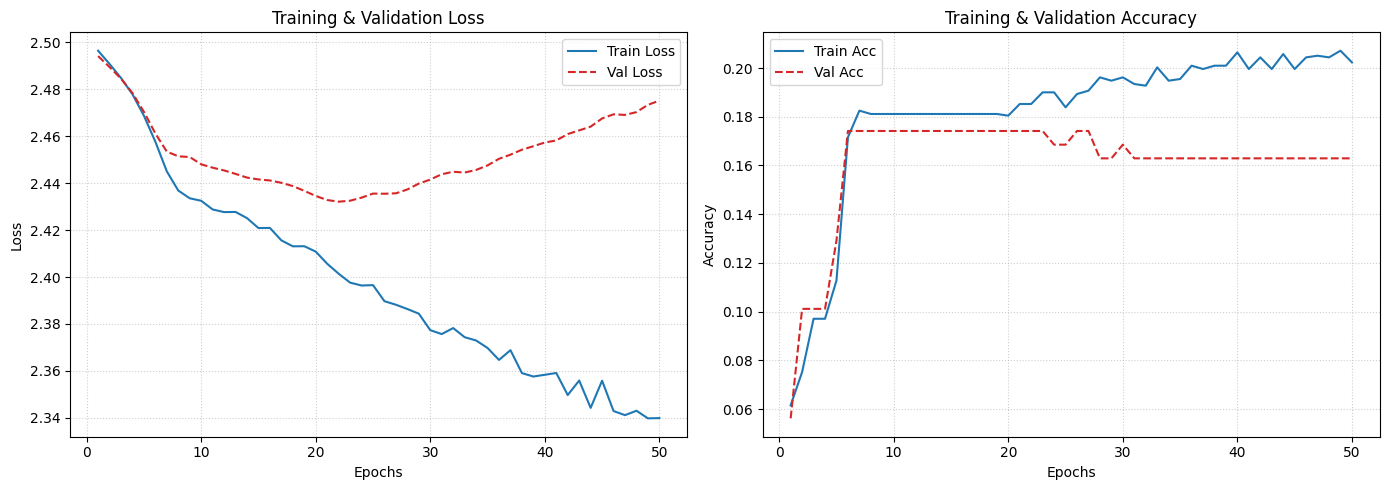

In [ ]:
plot_history(gc_rela_hist)

In [ ]:
def map_det_name(name):
    # Map tên class từ YOLO sang tập VOCAB của VRD
    name = name.lower()
    return name if name in node2id else 'unknown'

def yolo_detect(image_path, model_name='yolov8n.pt', conf=0.25):
    model = YOLO(model_name)
    results = model.predict(source=str(image_path), conf=conf, verbose=False)[0]

    dets = []
    for box in results.boxes:
        cls_id = int(box.cls.item())
        name = results.names[cls_id]
        xyxy = box.xyxy[0].tolist()
        conf = float(box.conf.item())
        dets.append((name, xyxy, conf))
    return dets

def infer_scene_graph(image_path, gnn_model, device):
    # 1. Detect Objects
    dets = yolo_detect(image_path)
    if not dets:
        print("No objects detected.")
        return

    # 2. Build Graph Nodes from Detections
    names = [map_det_name(d[0]) for d in dets]
    nodes = sorted(set(names)) # Unique objects

    if not nodes: return

    N = len(nodes)
    F = len(NODES_VOCAB)

    # Create features X
    X_np = np.stack([one_hot(node2id.get(n, 0), F) for n in nodes], axis=0)
    X = torch.from_numpy(X_np).unsqueeze(0).to(device) # [1, N, F]

    # Tạo đồ thị đầy đủ (Fully connected) hoặc dựa trên khoảng cách bbox (đơn giản dùng fully)
    # A: [1, N, N]
    A = torch.ones((1, N, N), device=device)
    Mask = torch.ones((1, N), device=device)

    # 3. Forward GNN Encoder
    gnn_model.eval()
    with torch.no_grad():
        # Lấy đặc trưng nút sau khi đã học ngữ cảnh
        H = gnn_model(X, A, Mask) # [1, N, Hid]

        # 4. Tạo tất cả các cặp (subj, obj) để dự đoán quan hệ
        pairs = []
        for i in range(N):
            for j in range(N):
                if i != j:
                    pairs.append([i, j])

        if not pairs: return

        pairs_tensor = torch.tensor([pairs], device=device) # [1, P, 2]

        # 5. Predict Relations
        logits = gnn_model.predict_edges(H, pairs_tensor) # [1, P, num_rels]
        probs = torch.softmax(logits, dim=-1)
        confs, preds = probs.max(dim=-1)

        # 6. In kết quả
        print(f"--- Scene Graph Inference for {image_path} ---")
        print(f"Detected Nodes: {nodes}")
        print("Predicted Relations:")

        pairs_list = pairs_tensor.cpu().numpy()[0]
        preds_list = preds.cpu().numpy()[0]
        confs_list = confs.cpu().numpy()[0]

        found_rel = False
        for idx, (p, rel_id, conf) in enumerate(zip(pairs_list, preds_list, confs_list)):
            rel_name = REL_NO_NONE[rel_id] if rel_id < len(REL_NO_NONE) else "none"

            # Chỉ in các quan hệ có độ tin cậy cao và không phải 'none' (nếu có class none)
            if conf > 0.2:
                s_name = nodes[p[0]]
                o_name = nodes[p[1]]
                print(f"  {s_name} --[{rel_name}]--> {o_name} (conf: {conf:.2f})")
                found_rel = True

        if not found_rel:
            print("  No confident relations found.")

# --- RUN DEMO ---
# Khởi tạo model
re_model = RelationExtractor(
    in_dim=len(NODES_VOCAB),
    hid_dim=64,
    num_rels=len(REL_NO_NONE)
).to(device)

# GCN cho bộ ba quan hệ từ MsCOCO + YOLO + caption, hướng tới captioning

In [ ]:
# 1. Gỡ cài đặt thư viện bị sai (Audio parser)
!pip uninstall -y sng_parser

# 2. Cài đặt thư viện đúng từ GitHub (Scene Graph Parser cho NLP)
!pip install git+https://github.com/vacancy/SceneGraphParser.git

# 3. Cài đặt mô hình ngôn ngữ cho Spacy
!python -m spacy download en_core_web_sm

# 4. Khởi động lại Runtime để áp dụng thay đổi
import os
import sys
import time

# Kiểm tra môi trường Colab để restart
if 'google.colab' in sys.modules:
    print("Đang khởi động lại Runtime...")
    time.sleep(1)
    os.kill(os.getpid(), 9)

  Cloning https://github.com/vacancy/SceneGraphParser.git to /tmp/pip-req-build-9bd402xg
  Running command git clone --filter=blob:none --quiet https://github.com/vacancy/SceneGraphParser.git /tmp/pip-req-build-9bd402xg
  Resolved https://github.com/vacancy/SceneGraphParser.git to commit 1b3d5fcacbf6bae5d4f6dc2672c77027df0a733f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 133.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Đang khởi động lại Runtime...


In [ ]:
import sng_parser
import spacy

# Kiểm tra thử xem đã parse được chưa
print("Kiểm tra thư viện sng_parser:")
graph = sng_parser.parse("A man is riding a horse.")
print(graph)
# Kết quả đúng sẽ in ra một dictionary chứa 'entities' và 'relations'

Kiểm tra thư viện sng_parser:
{'entities': [{'span': 'A man', 'lemma_span': 'a man', 'head': 'man', 'lemma_head': 'man', 'span_bounds': (0, 2), 'modifiers': [{'dep': 'det', 'span': 'A', 'lemma_span': 'a'}], 'type': 'unknown'}, {'span': 'a horse', 'lemma_span': 'a horse', 'head': 'horse', 'lemma_head': 'horse', 'span_bounds': (4, 6), 'modifiers': [{'dep': 'det', 'span': 'a', 'lemma_span': 'a'}], 'type': 'unknown'}], 'relations': [{'subject': 0, 'object': 1, 'relation': 'riding', 'lemma_relation': 'rid'}]}


In [ ]:
!pip install ultralytics

In [ ]:
import sng_parser
import torch
import torch.nn as nn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [ ]:
# ==========================================
# 1. GIẢ LẬP DỮ LIỆU MS COCO (Captioning)
# ==========================================
coco_samples = [
    {"image_id": 1, "file_name": "sample1.jpg", "caption": "A man is riding a horse on the beach."},
    {"image_id": 2, "file_name": "sample2.jpg", "caption": "A woman holding a red umbrella in the rain."},
    {"image_id": 3, "file_name": "sample3.jpg", "caption": "Two cats are playing with a ball on the grass."},
    {"image_id": 4, "file_name": "sample4.jpg", "caption": "A dog sits next to a bike."}
]

# ==========================================
# 2. HÀM CHUYỂN CAPTION -> SCENE GRAPH
# ==========================================
def parse_caption_to_graph(caption):
    """
    Sử dụng sng_parser để phân tích caption thành đồ thị ngữ nghĩa.
    Input: "A man is riding a horse"
    Output: Nodes (man, horse), Edges (riding)
    """
    # Parse caption
    graph_obj = sng_parser.parse(caption)

    entities = graph_obj['entities'] # Danh sách đối tượng (Nodes)
    relations = graph_obj['relations'] # Danh sách quan hệ (Edges)

    # Xây dựng danh sách node và edge
    nodes = []
    for e in entities:
        nodes.append(e['head']) # Lấy danh từ chính (VD: "red umbrella" -> "umbrella")

    triplets = []
    for r in relations:
        subj_idx = r['subject']
        obj_idx = r['object']
        rel_name = r['relation']

        triplets.append((subj_idx, rel_name, obj_idx))

    return nodes, triplets

# Test thử hàm parse
print("--- Demo Parsing Caption ---")
sample_cap = coco_samples[0]['caption']
nodes, triplets = parse_caption_to_graph(sample_cap)
print(f"Caption: {sample_cap}")
print(f"Nodes: {nodes}")
print(f"Triplets: {triplets}")
# Kết quả mong đợi: Nodes: ['man', 'horse', 'beach'], Triplets: [(0, 'riding', 1), (0, 'on', 2)]

--- Demo Parsing Caption ---
Caption: A man is riding a horse on the beach.
Nodes: ['man', 'horse', 'beach']
Triplets: [(0, 'riding', 1), (0, 'on', 2)]


In [ ]:
# ==========================================
# 3. MÔ HÌNH GCN CHO CAPTION SCENE GRAPH
# ==========================================

# Từ điển đơn giản để map từ vựng sang ID
word_vocab = {'<pad>': 0, '<unk>': 1}
def get_word_id(word):
    if word not in word_vocab:
        word_vocab[word] = len(word_vocab)
    return word_vocab[word]

class CaptionGCN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2):
        super(CaptionGCN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.gcn_layers = nn.ModuleList()
        # First GCN layer maps from embedding dimension to hidden dimension
        self.gcn_layers.append(nn.Linear(embed_dim, hidden_dim))
        # Subsequent GCN layers map from hidden dimension to hidden dimension
        for _ in range(num_layers - 1):
            self.gcn_layers.append(nn.Linear(hidden_dim, hidden_dim))

        self.relu = nn.ReLU()

        # Output layer để sinh đặc trưng cho Captioning Decoder
        self.fc_out = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, node_indices, adj_matrix):
        """
        node_indices: Tensor [B, N] chứa ID của các từ (node)
        adj_matrix: Tensor [B, N, N] ma trận kề
        """
        # 1. Embedding: [B, N] -> [B, N, Embed]
        x = self.embedding(node_indices)

        # 2. GCN Propagation: A * X * W
        for layer in self.gcn_layers:
            # Aggregate neighbors: AX
            # (B, N, N) x (B, N, current_dim) -> (B, N, current_dim)
            x = torch.bmm(adj_matrix, x)

            # Linear Transformation: XW
            x = layer(x) # (B, N, next_dim)
            x = self.relu(x)

        # 3. Output representation
        # Global Pooling (lấy trung bình các node để đại diện cho cả graph/câu)
        graph_embed = torch.mean(x, dim=1)
        graph_embed = self.fc_out(graph_embed)
        return graph_embed

In [ ]:
# ==========================================
# 4. TÍCH HỢP YOLO VÀ CHẠY THỬ NGHIỆM
# ==========================================

# Khởi tạo YOLO (dùng bản nano cho nhanh)
yolo_model = YOLO('yolov8n.pt')

# Khởi tạo model GCN
vocab_size = 1000 # Giả định
embed_dim = 64
hidden_dim = 128
model = CaptionGCN(vocab_size, embed_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def build_batch_data(samples, max_nodes=10):
    batch_nodes = []
    batch_adj = []

    for item in samples:
        # 1. Phân tích caption -> Graph
        nodes_str, triplets = parse_caption_to_graph(item['caption'])

        # Map từ vựng sang ID
        node_ids = [get_word_id(n) for n in nodes_str][:max_nodes]

        # Padding nếu thiếu node
        real_len = len(node_ids)
        if real_len < max_nodes:
            node_ids += [0] * (max_nodes - real_len)

        # Xây dựng ma trận kề (Adj)
        adj = np.eye(max_nodes) # Self-loop
        for (s, r, o) in triplets:
            if s < max_nodes and o < max_nodes:
                adj[s, o] = 1.0
                adj[o, s] = 1.0 # Vô hướng cho đơn giản

        batch_nodes.append(node_ids)
        batch_adj.append(adj)

    return torch.tensor(batch_nodes), torch.tensor(batch_adj, dtype=torch.float32)

print("--- Bắt đầu chạy thử nghiệm Mức 3 ---")

# Chạy thử 5 bước train giả lập
model.train()
for epoch in range(5):
    # Chuẩn bị dữ liệu từ batch mẫu
    node_idx, adj = build_batch_data(coco_samples)

    # Forward GCN
    graph_embedding = model(node_idx, adj)

    # Giả lập loss (ví dụ: muốn embedding này giống embedding ảnh từ YOLO)
    # Ở đây ta dùng dummy target là vector 0 để code chạy được
    target = torch.randn_like(graph_embedding)
    loss = nn.MSELoss()(graph_embedding, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

--- Bắt đầu chạy thử nghiệm Mức 3 ---
Epoch 1: Loss = 1.0931
Epoch 2: Loss = 1.1003
Epoch 3: Loss = 1.1328
Epoch 4: Loss = 1.0386
Epoch 5: Loss = 1.0452
